## Training the sentiment analysis model

The objective of this notebook is to train a Neural Network capable of classifying if a text is positive (hate/toxic/others) or not negative.

The data to train this model was taken from https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from keras.layers import (
    Input,
    Concatenate,
    Dense,
    Activation,
    TextVectorization,
    Embedding,
    GlobalAveragePooling1D,
    Conv1D,
    AveragePooling1D,
    Reshape,
    LSTM,
)
from keras.models import Model
import tensorflow as tf

# tf.debugging.set_log_device_placement(True)

2023-04-25 12:24:34.713458: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 12:24:34.766643: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 12:24:34.767987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 12:24:35.547853: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge
df = pd.read_csv("data/toxic_train.csv")

In [4]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
df["is_negative"] = (df.toxic | df.severe_toxic | df.obscene | df.threat | df.insult | df.identity_hate).astype(int)
df["is_negative"].value_counts()

is_negative
0    143346
1     16225
Name: count, dtype: int64

In [6]:
# Resample the dataset to have a balanced number of positive and negative examples
df_negative = df[df["is_negative"] == 1]
df_positive = df[df["is_negative"] == 0].sample(n=len(df_negative), random_state=42)

df = pd.concat([df_negative, df_positive])
df["is_negative"].value_counts()

is_negative
1    16225
0    16225
Name: count, dtype: int64

In [7]:
y = df["is_negative"].to_numpy()
X = df["comment_text"].to_numpy()

ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y.reshape(-1, 1)).todense()
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe)

In [13]:
def convolve_and_downsample(input_n_samples, input_embedding_size, n_filters, kernel_size=3, **kwargs):
    input_layer = Input(shape=(input_n_samples,input_embedding_size))
    x = input_layer
    x = Conv1D( filters=n_filters,
                kernel_size=kernel_size,
                padding='same',
                use_bias=False,
                )(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = Activation('elu')(x)
    return Model(input_layer, x, **kwargs)

vocab_size = 10_000
def deep_cnn_embedding_softmax_model(vectorize_layer, vocab_size=vocab_size, number_of_ngrams=32, n_gram_size=3):
    input_layer = Input(shape=(1,), dtype=tf.string)
    x = input_layer
    x = vectorize_layer(x)
    x = Embedding(vocab_size, 2, name='projecao')(x)
    x = convolve_and_downsample(256, 2, number_of_ngrams, n_gram_size, name='ngramas')(x)
    x = convolve_and_downsample(128, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(64, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(32, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(16, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(8, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(4, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(2, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = Reshape((-1,))(x)
    x = Dense(2, name='classificador')(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)

def blstm_softmax_model(vectorize_layer, vocab_size=vocab_size):
    input_layer = Input(shape=(1,), dtype=tf.string)
    x = input_layer
    x = vectorize_layer(x)
    x = Embedding(vocab_size, 2, name='projecao')(x)
    x1 = LSTM(1)(x)
    x2 = LSTM(1, go_backwards=True)(x)
    x = Concatenate()([x1, x2])
    x = Dense(2, name='classificador')(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)


In [14]:
vectorize_layer = TextVectorization(output_mode='int', max_tokens=vocab_size, pad_to_max_tokens=True, output_sequence_length=256)
vectorize_layer.adapt(X_train)
# clf2 = deep_cnn_embedding_softmax_model(vectorize_layer)
clf2 = blstm_softmax_model(vectorize_layer)
print(clf2.summary())
clf2.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = clf2.fit(X_train, y_train, epochs=40, verbose=1, validation_split=0.1)
clf2.evaluate(X_test, y_test)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 256)         0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 projecao (Embedding)           (None, 256, 2)       20000       ['text_vectorization[0][0]']     
                                                                                                  
 lstm (LSTM)                    (None, 1)            16          ['projecao[0][0]']           

[0.2616928517818451, 0.9100209474563599]

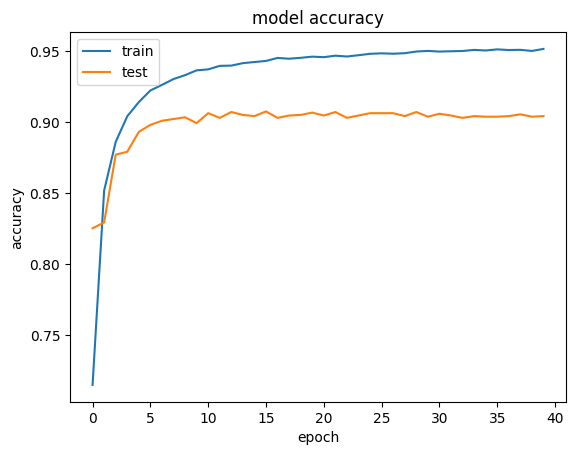

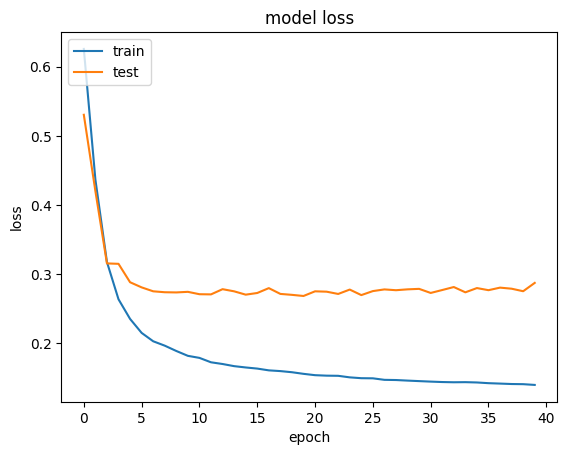

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [9]:
# Open the saved model
clf2 = tf.keras.models.load_model("models/CLASS_MODEL")

2023-04-25 12:25:31.096370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 12:25:31.097121: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-25 12:25:31.310015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gra

In [10]:
positive = [
    "I love my job.",
    "I am happy with the result of my project.",
    "The sun is shining and the day is wonderful.",
    "The food at the restaurant was delicious.",
    "The sun is shining and the day is wonderful.",
    "I am excited for my vacation trip.",
    "I love spending time with my family.",
    "I was promoted at work today!",
    "I love eating pizza on weekends.",
    "My team won the championship!",
    "Today is a beautiful day to enjoy the outdoors.",
    "I am very excited for summer vacation.",
    "My best friend surprised me with an amazing present.",
    "I just got tickets to my favorite band's show.",
    "I love going out to dinner at a fancy restaurant.",
    "I got a compliment from my boss for the work I did.",
]


negative = [
    "I hate my job.",
    "Fuck this"
    "I am sad with the result of my project.",
    "The sun is not shining and the day is horrible.",
    "The food at the restaurant was disgusting.",
    "The sun is not shining and the day is horrible.",
    "I am not excited for my vacation trip.",
    "I hate spending time with my family.",
    "I was demoted at work today!",
    "I hate eating pizza on weekends.",
    "My team lost the championship!",
    "Today is a horrible day to enjoy the outdoors.",
    "I am very sad for summer vacation.",
    "My best friend betrayed me with an amazing present.",
    "I just got tickets to my favorite band's show.",
    "I hate going out to dinner at a fancy restaurant.",
    "I got a complaint from my boss for the work I did.",
]

print((ohe.inverse_transform(clf2.predict(positive)) == 0).sum() / len(positive))
print((ohe.inverse_transform(clf2.predict(negative)) == 1).sum() / len(negative))

2023-04-25 12:25:45.336334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-25 12:25:45.339057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-25 12:25:45.340719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
0.9375
1/1 [==============================] - 0s 62ms/step
0.4375


In [17]:
# clf2.save("COLOCAR O CAMINHO PARA SALVAR O MODELO")

INFO:tensorflow:Assets written to: LSTM_model_91\assets


INFO:tensorflow:Assets written to: LSTM_model_91\assets
